# Comparing Personalization: LOSO vs Within-Subjects

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow compares a within-subject experimental design to the leave-one-subject-out (LOSO) design. In the first case, one model is trained per subject using only that subject's data. In the second case, for each subject, a model is trained using data from all other subjects and then applied to the target subject. The within-subject design thus corresponds to a personalized model fit to an individual subject, while the LOSO design corresponds to using a model fit to other subjects.  We use the ExtraSensory data set sleeping prediction task using a subset of the first 50,000 instances. The model used is logistic regression with a default regularization hyper-parameters. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, and a missing label filter that removes instances without labels. Next, the workflow performs mean imputation followed by feature normalization. Finally,  each of the two experimental protocols are applied. Results are displayed per-subject.

In this particular case, we see that the accuracy measured by the within-subject protocol is slightly better than that of the LOSO design, but the difference does not look significant. Further, it is important to remember that the LOSO and within-subjects test sets are not the same due to the fact that some data for each subject are used for training in the within-subject design, so more work is needed to conclusively state that personalization provides an advantage for this task.


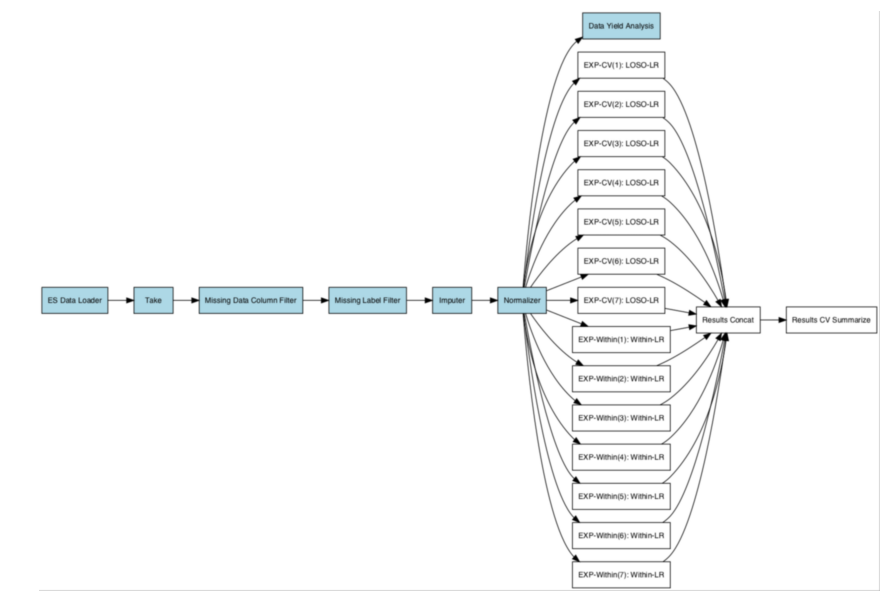

Running step EXP-Within(7): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(6): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(5): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(4): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(3): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(2): Within-LR
  Fitting and testing Within-LR

Running step EXP-Within(1): Within-LR
  Fitting and testing Within-LR

Running step EXP-CV(7): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(6): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(5): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(4): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(3): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(2): LOSO-LR
  Fitting and testing LOSO-LR

Running step EXP-CV(1): LOSO-LR
  Fitting and testing LOSO-LR

Running step Results Concat
  Concatenating Results


accuracy_score  f1_score  precision_score  recall_score
Method    Fold                                                         
LOSO-LR   1           0.867829  0.794464         0.720488      0.885369
          2           0.819727  0.796986         0.670215      0.982900
          3           0.662283  0.365028         0.647858      0.254098
          4           0.902098  0.888617         0.916281      0.862574
          5           0.873016  0.012346         0.022388      0.008523
          6           0.866006  0.397452         0.314516      0.539792
          7           0.802399  0.767055         0.805944      0.731746
Within-LR 1           0.814716  0.768588         0.934959      0.652482
          2           0.932011  0.000000         0.000000      0.000000
          3           0.693271  0.523114         0.951327      0.360738
          4           0.897707  0.938559         1.000000      0.884232
          5           0.998677  0.000000         0.000000      0.000000
          6           0.710162  0.665742         0.997921      0.499480
          7           0.946237  0.948718         0.905383      0.996409


Running step Results CV Summarize
  Summarizing CV results table


accuracy_score            f1_score           precision_score  \
                    mean       sem      mean       sem            mean   
Method                                                                   
LOSO-LR         0.827623  0.030368  0.574564  0.121975        0.585384   
Within-LR       0.856112  0.045111  0.549246  0.152507        0.684227   

                    recall_score            
                sem         mean       sem  
Method                                      
LOSO-LR    0.117293     0.609286  0.136875  
Within-LR  0.177118     0.484763  0.149210


  Workflow complete



In [11]:
metrics   = [accuracy_score, f1_score, precision_score, recall_score]
df_raw    = extrasensory_data_loader(label="SLEEPING");
df_sub    = Take(df_raw, 50000)
df_cf     = MisingDataColumnFilter(df_sub);
df_lf     = MisingLabelFilter(df_cf);
df_imp    = Imputer(df_lf)
df_norm   = Normalizer(df_imp);
report    = DataYieldReport(df_norm, names=["Norm"])

flow      = workflow([report]);
output    = flow.run();
num       = output['Data Yield Analysis']['report']["#Individuals with Data"]["Norm"]

estimators1 = {"Within-LR": LogisticRegression(solver="lbfgs",max_iter=100)}
res_within = ExpWithin(df_norm, estimators1, metrics=metrics, n_folds=num);

estimators2 = {"LOSO-LR": LogisticRegression(solver="lbfgs",max_iter=100)}
res_loso   = ExpCV(df_norm, estimators2, metrics=metrics, n_folds=num);

res_cat   = ResultsConcat(res_loso, res_within)
summary   = ResultsCVSummarize(res_cat)
flow.add([summary])
 
flow.draw(); plt.show();
output=flow.run();